# Initialize

## ASW session

In [150]:
import boto3

session = boto3.Session()
s3 = session.resource('s3')

## SageMaker Session

In [151]:
import sagemaker

sage_session = sagemaker.Session()

# Define Globals

In [152]:
# bucket name
bucket = 'aida-project'

# path for s3_input
s3_path = f"s3://{bucket}/"

## define source files
# TRAIN source file
train_source_path = 'team_remote'
train_source_name = 'title-train.csv'
#train_source_name = 'title-valid.csv'       # for testing; remove later


# VALID source file
valid_source_path = 'team_remote'
valid_source_name = 'title-valid.csv'
#valid_source_name = 'title-test.csv'       # for testing; remove later

# TEST source file
test_source_path = 'team_remote'
test_source_name = 'title-test.csv'

# output for result
output_path ='team_remote'
output_location = f'{s3_path}{output_path}/output'

In [153]:
print(output_location)

s3://aida-project/team_remote/output


In [154]:
# Create pointers to the S3 train and test datasets

from sagemaker import s3_input

# print(f"{s3_path}{train_source_path}/{train_source_name}")
# print(f"{s3_path}{valid_source_path}/{valid_source_name}")
# print(f"{s3_path}{test_source_path}/{test_source_name}")
s3_input_train = sagemaker.session.s3_input(s3_data=f"{s3_path}{train_source_path}/{train_source_name}", content_type="text/csv")
s3_input_valid = sagemaker.session.s3_input(s3_data=f"{s3_path}{valid_source_path}/{valid_source_name}", content_type="text/csv")
s3_input_test = sagemaker.session.s3_input(s3_data=f"{s3_path}{test_source_path}/{test_source_name}", content_type="text/csv")

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [155]:
role = sagemaker.get_execution_role()

# Define Model

In [156]:
# finde pre-defined models here:
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

# Create an XGBoost Estimator

# estimator call
# <ecr_path>/sagemaker-xgboost:1.2-1
    
ecr_path = "492215442770.dkr.ecr.eu-central-1.amazonaws.com"
xgboost_estimator = f"{ecr_path}/sagemaker-xgboost:1.0-1-cpu-py3"

# ecr_path = "664544806723.dkr.ecr.eu-central-1.amazonaws.com"
# knn_estimator = f"{ecr_path}/knn:latest"


In [157]:
xgboost = sagemaker.estimator.Estimator(xgboost_estimator,
                              role,
                              train_instance_count=1,
                              train_instance_type="ml.m5.4xlarge",
                              output_path=output_location,
                              sagemaker_session=sage_session,
                              base_job_name="JPC-xgboost")

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [159]:
# Select the your specific hyperparameters (Optional)
# https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#learning-task-parameters 

xgboost.set_hyperparameters(
    eta=.35,
    num_round=252,                     # required parameter!
    objective = 'reg:linear',
    )

In [160]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.estimator import Estimator 
save_interval = 50
xgboost_debugger = Estimator( role=role, 
                             base_job_name="JPC-xgboost-debug", 
                             train_instance_count=1, 
                             train_instance_type='ml.m5.4xlarge', 
                             image_name=xgboost_estimator, 
                             #hyperparameters=hyperparameters, 
                             train_max_run=1800, 
                             debugger_hook_config=DebuggerHookConfig( s3_output_path=output_location, # Required 
                             collection_configs=[ CollectionConfig( name="feature_importance", parameters={ "save_interval": str(save_interval) } ), ], ), 
                              rules=[ Rule.sagemaker( rule_configs.loss_not_decreasing(), 
                                                     rule_parameters={ "collection_names": "metrics", "num_steps": str(save_interval * 2), }, ), ],
)
xgboost_debugger.set_hyperparameters(
    eta=.35,
    num_round=252,                     # required parameter!
    objective = 'reg:linear',
    )

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


## Fit Model

In [161]:
xgboost_debugger.fit({"train": s3_input_train, "validation": s3_input_valid}, wait=True)

2020-11-19 16:46:58 Starting - Starting the training job...
2020-11-19 16:47:22 Starting - Launching requested ML instances
********* Debugger Rule Status *********
*
*  LossNotDecreasing: InProgress        
*
****************************************
......
2020-11-19 16:48:23 Starting - Preparing the instances for training......
2020-11-19 16:49:24 Downloading - Downloading input data
2020-11-19 16:49:24 Training - Downloading the training image...
2020-11-19 16:49:44 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is 

In [162]:
#!pip install smdebug
from smdebug.trials import create_trial
s3_output_path = xgboost_debugger.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-11-19 16:51:28.812 ip-172-16-29-248:6712 INFO s3_trial.py:42] Loading trial debug-output at path s3://aida-project/team_remote/output/JPC-xgboost-debug-2020-11-19-16-46-57-820/debug-output


In [163]:
#trial.tensor_names()

In [164]:
trial.tensor("feature_importance/cover/f0").values()

[2020-11-19 16:51:33.573 ip-172-16-29-248:6712 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-11-19 16:51:34.594 ip-172-16-29-248:6712 INFO trial.py:210] Loaded all steps


{50: array([0.04307063]),
 100: array([0.03059408]),
 150: array([0.03497543]),
 200: array([0.03457847]),
 250: array([0.03615072])}

In [165]:
liste = trial.tensor_names()

In [166]:
#[k for k in lst if 'ab' in k]
feature_importance_names = [k for k in liste if 'feature_importance/cover' in k]
feature_importance_col_names = ['isAdult', 'startYear', 'endYear', 'numVotes', 'Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Reality-TV', 'Family', 'Fantasy', 'Game-Show', 'Adult', 'History', 'Mystery', 'Musical', 'Animation', 'Music', 'Film-Noir', 'shortGenre', 'Horror', 'Western', 'Biography', 'Comedy', 'Action', 'Sport', 'Talk-Show', 'Sci-Fi', 'News', 'movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort', 'tvSpecial', 'video', 'videoGame', 'distinct languages', 'distinct regions']
feature_importance_weight = [k for k in liste if 'feature_importance/weight' in k]

7


In [167]:
feat_dict_start={}
feat_dict_ende={}
start=50
ende=250
for i,f in enumerate(feature_importance_names):
    #print(feature_importance_col_names[i],"\t\t",end='')
    #print(trial.tensor(f).values())
    #print(trial.tensor(f).values()[40][0])
    index=int(f.split('f')[2])
    try:
        feat_dict_start[feature_importance_col_names[index]]=trial.tensor(f).values()[start][0]
    except:
        feat_dict_start[feature_importance_col_names[index]]=0
    #break
print(feat_dict_start)
for i,f in enumerate(feature_importance_names):
    index=int(f.split('f')[2])
    try:
        feat_dict_ende[feature_importance_col_names[index]]=trial.tensor(f).values()[ende][0]
    except:
        feat_dict_ende[feature_importance_col_names[index]]=0
print(feat_dict_ende)

{'isAdult': 0.043070633060439546, 'startYear': 0.007380599209238163, 'Documentary': 0.01680715591483466, 'Reality-TV': 0.014729369591736773, 'Family': 0.008675791912772459, 'Fantasy': 0.018864678649165335, 'Game-Show': 0.019857007618346297, 'Adult': 0.0111572589578705, 'History': 0.03569844428840835, 'Mystery': 0.026027873911947212, 'Musical': 0.004243897242865821, 'Animation': 0.010987531128428775, 'endYear': 0.023886251401637394, 'Music': 0.019636491752060985, 'Film-Noir': 0, 'shortGenre': 0.0047985481200190135, 'Horror': 0.023522206981917097, 'Western': 0.045496208101381094, 'Biography': 0.02403963828534207, 'Comedy': 0.005559561293491315, 'Action': 0.005575477818618715, 'Sport': 0.012658318095690086, 'Talk-Show': 0.023573496069841087, 'numVotes': 0.010704162928185374, 'Sci-Fi': 0.0298902649955347, 'News': 0.05429731831675873, 'movie': 0.025938731072778817, 'short': 0.01783569714452138, 'tvEpisode': 0.012901508832324, 'tvMiniSeries': 0.0772715932370043, 'tvMovie': 0.0141516904094863

In [168]:
feat_weight_dict={}
for i,f in enumerate(feature_importance_weight):
    index=int(f.split('f')[2])
    print(feature_importance_col_names[index],"\t\t",end='')
    print("i,f:",str(i)," ", f)
    print(trial.tensor(f).values())
    #print(trial.tensor(f).values()[40][0])
    feat_weight_dict[feature_importance_col_names[index]]=trial.tensor(f).values()[ende][0]
    #break
#print(feat_weight_dict)

isAdult 		i,f: 0   feature_importance/weight/f0
{50: array([0.00292778]), 100: array([0.00424809]), 150: array([0.00398997]), 200: array([0.00360021]), 250: array([0.00393266])}
startYear 		i,f: 1   feature_importance/weight/f1
{0: array([0.23728814]), 50: array([0.18867925]), 100: array([0.18249788]), 150: array([0.18661651]), 200: array([0.184982]), 250: array([0.18469712])}
Documentary 		i,f: 2   feature_importance/weight/f10
{0: array([0.05084746]), 50: array([0.017892]), 100: array([0.01699235]), 150: array([0.01641587]), 200: array([0.01645808]), 250: array([0.01573065])}
Reality-TV 		i,f: 3   feature_importance/weight/f11
{0: array([0.05084746]), 50: array([0.01724138]), 100: array([0.01614274]), 150: array([0.01561788]), 200: array([0.01585805]), 250: array([0.01566165])}
Family 		i,f: 4   feature_importance/weight/f12
{50: array([0.0214704]), 100: array([0.02090059]), 150: array([0.01972184]), 200: array([0.01980113]), 250: array([0.01952532])}
Fantasy 		i,f: 5   feature_impor

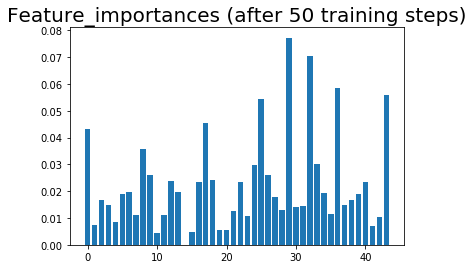

Text(0.5, 1.0, 'Feature_importances (after 250 training steps)')

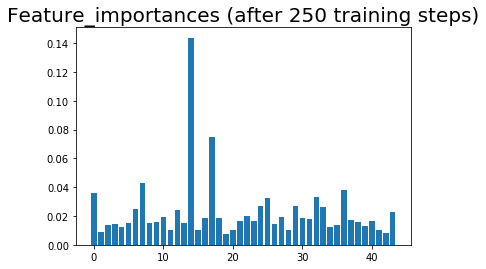

In [170]:
import matplotlib.pyplot as plt
plt.bar(range(len(feat_dict_start)),list(feat_dict_start.values()))
plt.title(f"Feature_importances (after {start} training steps)", fontsize=20)
plt.show()
plt.bar(range(len(feat_dict_ende)),list(feat_dict_ende.values()))
plt.title(f"Feature_importances (after {ende} training steps)", fontsize=20)

Text(0.5, 1.0, 'Feature_importances_weight')

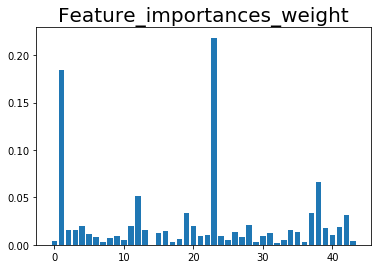

In [171]:
plt.bar(range(len(feat_weight_dict)),list(feat_weight_dict.values()))
plt.title("Feature_importances_weight", fontsize=20)

In [172]:
import pandas as pd




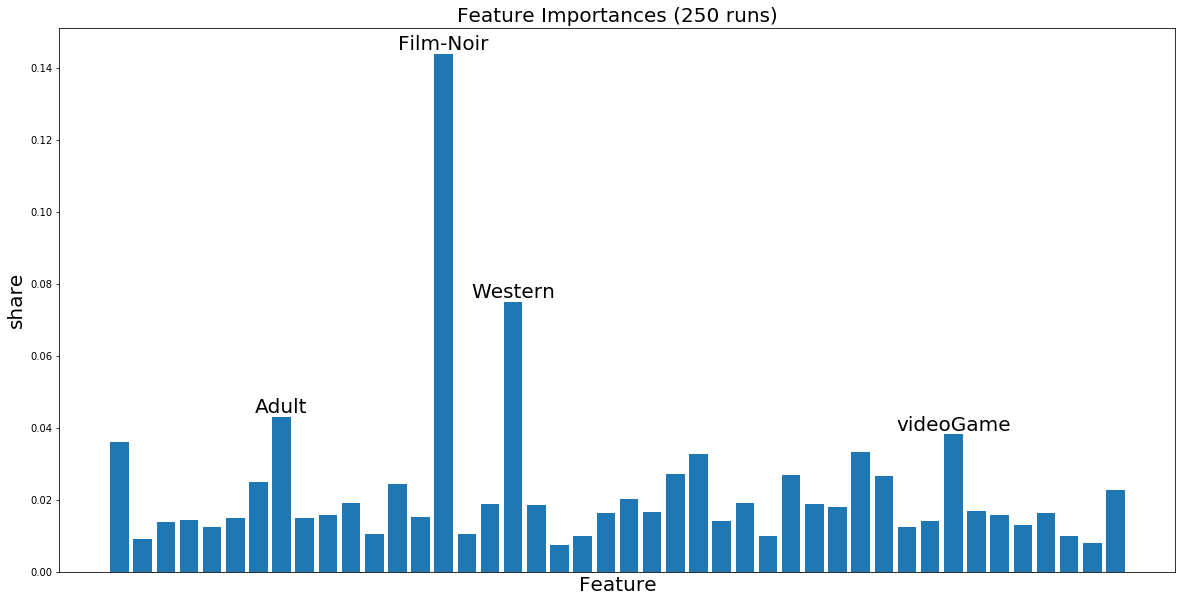

In [175]:
from datetime import datetime

now = datetime.now() # current date and time
time = now.strftime("%m-%d-%Y-%H-%M-%S")
#print(time)

dict = feat_dict_ende

fig,ax = plt.subplots(figsize=(20,10))

#pd.DataFrame(feat_dict, index=['quantity']).plot(kind='bar',ax=ax,use_index=False, legend=False,width=1.4)
plt.bar(*zip(*dict.items()))
plt.title(f'Feature Importances ({ende} runs)', fontsize=20)
plt.xlabel('Feature', fontsize=20)
plt.ylabel('share', fontsize=20)
plt.xticks(ticks=[])
threshold=0.038
pad=0.001
i=0
for k,v in dict.items():
    if v > threshold:
        ax.text(i,v+pad,k.replace(" ","\n"),horizontalalignment='center',fontsize=20)
    #reak
    i +=1
#plt.xlim([0,10])
#plt.ylim([0,10])
#plt.plot([0,10],[0,10], c='red')

#plt.show()
save_it=True
if save_it == True:
    filename='Feature_importance_1-'+time
    plt.savefig(filename, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')
plt.show()

In [176]:
sum=0
for k,v in feat_dict_ende.items():
    sum=sum+v
print(round(sum,7))

1.0


# Deploy Model

## Deploy

In [ ]:
# Deploy  model to an endpoint

xgb_predictor = xgboost_debugger.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------

## Configure Predictor

In [30]:
# Configure the predictor's serializer and deserializer

# INSERT CODE HERE

from sagemaker.predictor import csv_serializer, json_deserializer

xgb_predictor.content_type = "text/csv"
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = json_deserializer

# Display Endpoint

In [31]:
xgb_predictor.endpoint

'JPC-xgboost-debug-2020-11-19-12-54-04-221'

# Prediction

In [32]:
# carefully just one prediction
import pandas as pd
import matplotlib.pyplot as plt

col_names = ['averageRating', 'isAdult', 'startYear', 'endYear', 'numVotes', 'Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Reality-TV', 'Family', 'Fantasy', 'Game-Show', 'Adult', 'History', 'Mystery', 'Musical', 'Animation', 'Music', 'Film-Noir', 'shortGenre', 'Horror', 'Western', 'Biography', 'Comedy', 'Action', 'Sport', 'Talk-Show', 'Sci-Fi', 'News', 'movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie', 'tvSeries', 'tvShort', 'tvSpecial', 'video', 'videoGame', 'distinct languages', 'distinct regions']
test = pd.read_csv(f"{s3_path}{test_source_path}/{test_source_name}", header=0, index_col=False, names=col_names)
prediction=[]
for i in range(test.shape[0]):
    prediction.append(xgb_predictor.predict(test.iloc[i, 1:]))
    if i % 5000 == 0:
        print(i)
    #     print(prediction)
    #     print(test.iloc[i,0])
#print(prediction) 

#plt.scatter(test.iloc[:,0], prediction)


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000


11-19-2020-13-57-49


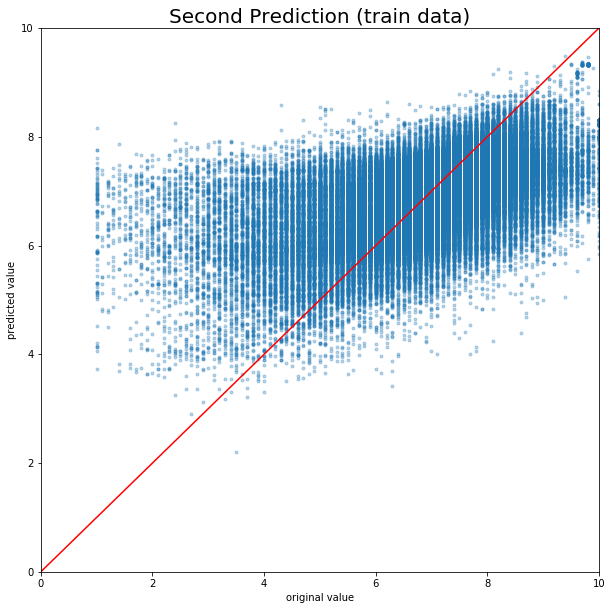

In [34]:
from datetime import datetime

now = datetime.now() # current date and time
time = now.strftime("%m-%d-%Y-%H-%M-%S")
print(time)



fig = plt.subplots(figsize=(10,10))
plt.scatter(test.iloc[:,0], prediction,marker='.',alpha=0.3)
plt.title('Second Prediction (train data)', fontsize=20)
plt.xlabel('original value')
plt.ylabel('predicted value')
plt.xlim([0,10])
plt.ylim([0,10])
plt.plot([0,10],[0,10], c='red')

#plt.show()
filename='Prediction-'+time
plt.savefig(filename, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait')


11-18-2020-14-55-10
